In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

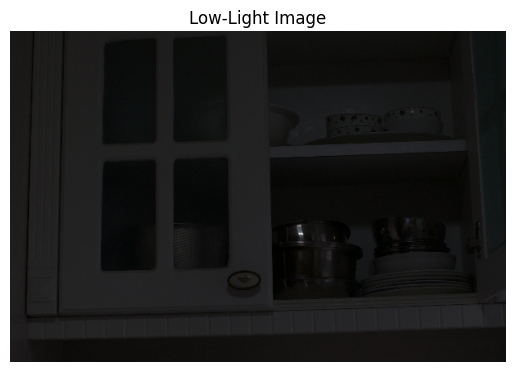

In [13]:
import cv2
import matplotlib.pyplot as plt

# Load an image (change the path accordingly)
image_path = "/content/79.png"  # Example path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

# Show the image
plt.imshow(image)
plt.axis("off")
plt.title("Low-Light Image")
plt.show()


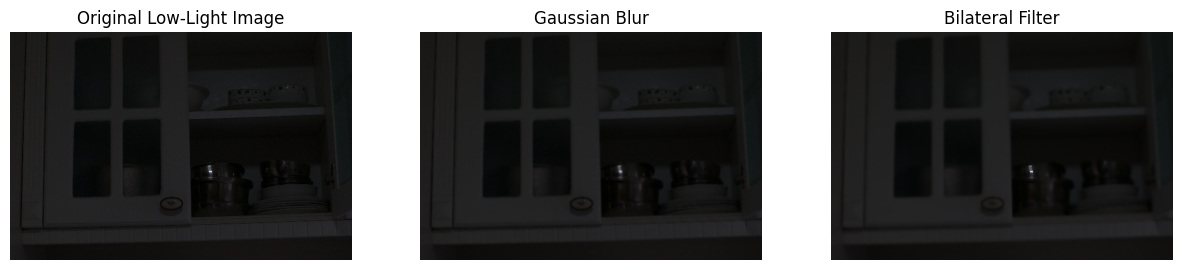

In [14]:
# Apply Gaussian Blur (Linear Filter)
gaussian_filtered = cv2.GaussianBlur(image, (5,5), 0)

# Apply Bilateral Filter (Non-Linear Filter)
bilateral_filtered = cv2.bilateralFilter(image, 9, 75, 75)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Low-Light Image")
ax[0].axis("off")

ax[1].imshow(gaussian_filtered)
ax[1].set_title("Gaussian Blur")
ax[1].axis("off")

ax[2].imshow(bilateral_filtered)
ax[2].set_title("Bilateral Filter")
ax[2].axis("off")

plt.show()


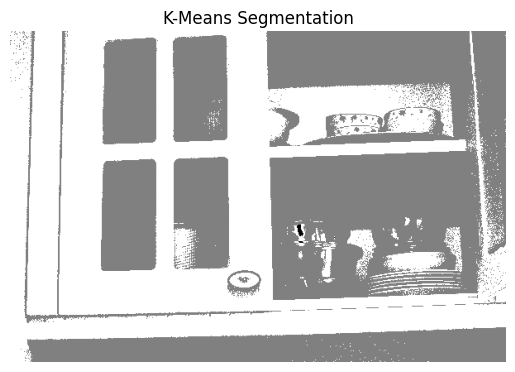

In [15]:
import numpy as np

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Reshape image for clustering
Z = gray.reshape((-1, 1))
Z = np.float32(Z)

# Apply K-Means Clustering
K = 3  # Number of clusters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
segmented_image = labels.reshape(gray.shape)

# Display result
plt.imshow(segmented_image, cmap="gray")
plt.title("K-Means Segmentation")
plt.axis("off")
plt.show()


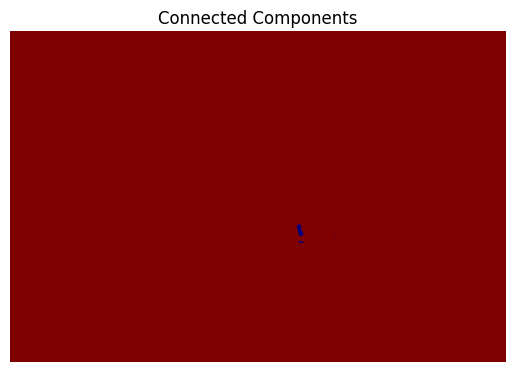

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Ensure segmented image is of type uint8
segmented_uint8 = np.uint8(segmented_image)

# Apply Connected Components
num_labels, labels_im = cv2.connectedComponents(segmented_uint8)

# Display results
plt.imshow(labels_im, cmap="jet")
plt.title("Connected Components")
plt.axis("off")
plt.show()


In [18]:
def iou(segmentation, ground_truth):
    intersection = np.logical_and(segmentation, ground_truth)
    union = np.logical_or(segmentation, ground_truth)
    return np.sum(intersection) / np.sum(union)

# Example ground truth mask
ground_truth = np.zeros_like(np.uint8(segmented_image))
ground_truth[50:150, 50:150] = 1  # Example object

# Compute IoU
iou_score = iou(segmented_image > 128, ground_truth)
print("IoU Score:", iou_score)


IoU Score: 0.0


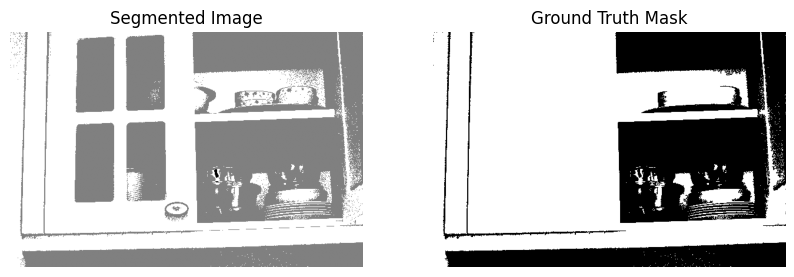

Updated IoU Score: 0.761335458146255


In [19]:
import numpy as np
import cv2

# Ensure segmented image is binary
segmentation_binary = (segmented_image == np.max(segmented_image)).astype(np.uint8)

# Find contours and generate an adaptive ground truth mask
contours, _ = cv2.findContours(segmentation_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ground_truth = np.zeros_like(segmentation_binary, dtype=np.uint8)
cv2.drawContours(ground_truth, contours, -1, (1), thickness=cv2.FILLED)  # Use 1 instead of 255 for consistency

# Compute IoU
def iou(segmentation, ground_truth):
    intersection = np.logical_and(segmentation, ground_truth)
    union = np.logical_or(segmentation, ground_truth)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(segmented_image, cmap="gray")
    ax[0].set_title("Segmented Image")
    ax[0].axis("off")

    ax[1].imshow(ground_truth, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    plt.show()
    return np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0

iou_score = iou(segmentation_binary, ground_truth)
print("Updated IoU Score:", iou_score)


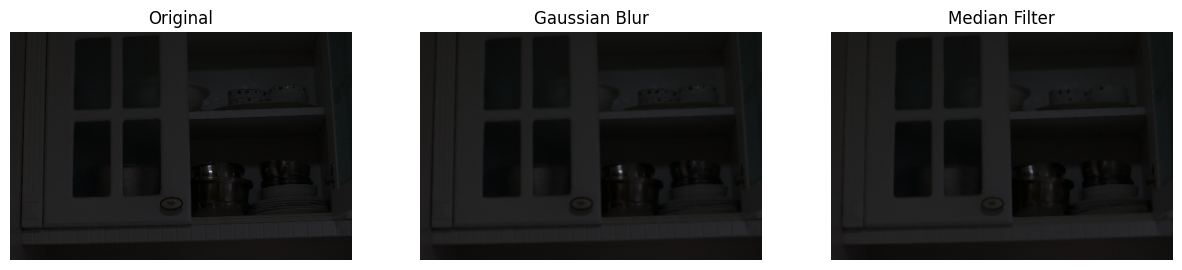

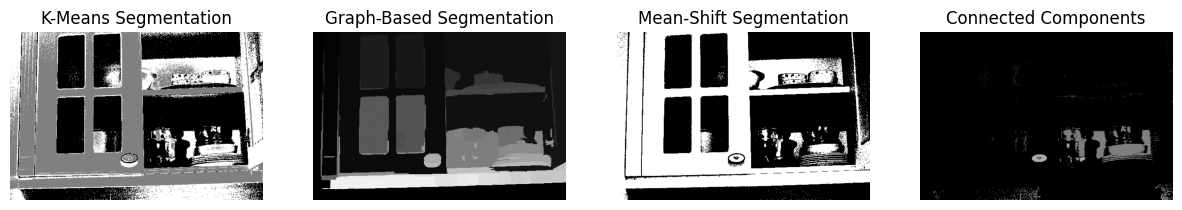

IoU Score: 0.4194
Dice Coefficient: 0.4561
Pixel Accuracy: 0.3851


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_images(images, titles, cmap=None):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap=cmap)
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    plt.show()

def apply_filters(image):
    gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 0)
    median_filtered = cv2.medianBlur(image, 5)
    show_images([image, gaussian_filtered, median_filtered], ["Original", "Gaussian Blur", "Median Filter"])
    return gaussian_filtered, median_filtered

def kmeans_segmentation(image, k=3):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(pixel_values)
    segmented_image = labels.reshape(image.shape[:2])
    return segmented_image

def graph_based_segmentation(image):
    return felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

def mean_shift_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    thresh_val = threshold_otsu(gray)
    segmented = (gray > thresh_val).astype(np.uint8) * 255
    return segmented

def connected_components(segmented_image):
    segmented_uint8 = np.uint8(segmented_image)
    num_labels, labels_im = cv2.connectedComponents(segmented_uint8)
    return labels_im

def compute_iou(segmentation, ground_truth):
    intersection = np.logical_and(segmentation, ground_truth)
    union = np.logical_or(segmentation, ground_truth)
    return np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0

def compute_dice(segmentation, ground_truth):
    intersection = np.logical_and(segmentation, ground_truth)
    return (2.0 * np.sum(intersection)) / (np.sum(segmentation) + np.sum(ground_truth))

def compute_pixel_accuracy(segmentation, ground_truth):
    return np.sum(segmentation == ground_truth) / ground_truth.size

# Example Usage
image_path = "/content/79.png"  # Update with actual path
image = load_image(image_path)

gaussian_filtered, median_filtered = apply_filters(image)
seg_kmeans = kmeans_segmentation(image)
seg_graph = graph_based_segmentation(image)
seg_mean_shift = mean_shift_segmentation(image)
conn_comp = connected_components(seg_kmeans)

# Display segmentation results
show_images([seg_kmeans, seg_graph, seg_mean_shift, conn_comp],
            ["K-Means Segmentation", "Graph-Based Segmentation", "Mean-Shift Segmentation", "Connected Components"], cmap="gray")

# Generate synthetic ground truth for evaluation
ground_truth = (seg_kmeans == np.max(seg_kmeans)).astype(np.uint8)

# Compute evaluation metrics
iou_score = compute_iou(seg_kmeans, ground_truth)
dice_score = compute_dice(seg_kmeans, ground_truth)
pixel_acc = compute_pixel_accuracy(seg_kmeans, ground_truth)

print(f"IoU Score: {iou_score:.4f}")
print(f"Dice Coefficient: {dice_score:.4f}")
print(f"Pixel Accuracy: {pixel_acc:.4f}")

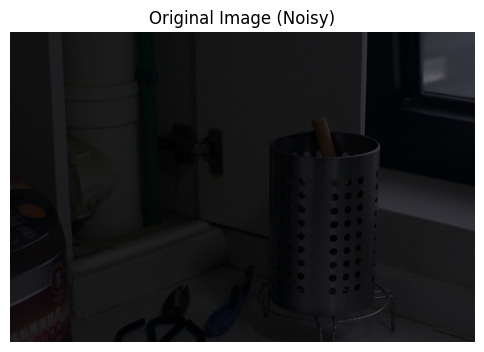

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image from dataset (change path as needed)
image_path = "/content/111.png"
# Check if the image file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at: {image_path}")

image = cv2.imread(image_path)

# Check if image loading was successful
if image is None:
    raise IOError(f"Error loading image from: {image_path}. Check file format and permissions.")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

# Display the original image
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title("Original Image (Noisy)")
plt.axis("off")
plt.show()

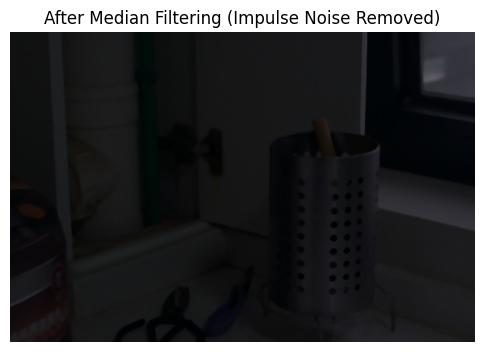

In [25]:
# Apply Median Filter with kernel size 5
median_filtered = cv2.medianBlur(image, 5)

# Display the result
plt.figure(figsize=(6,6))
plt.imshow(median_filtered)
plt.title("After Median Filtering (Impulse Noise Removed)")
plt.axis("off")
plt.show()


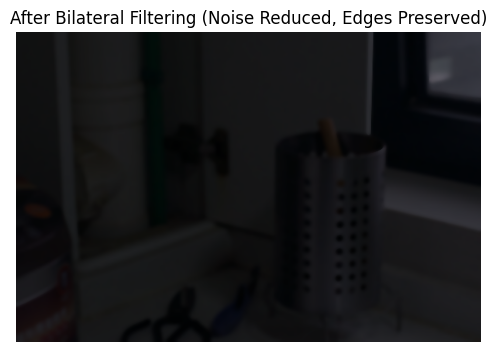

In [26]:
# Apply Bilateral Filter (d=9, sigmaColor=75, sigmaSpace=75)
bilateral_filtered = cv2.bilateralFilter(median_filtered, 9, 75, 75)

# Display the result
plt.figure(figsize=(6,6))
plt.imshow(bilateral_filtered)
plt.title("After Bilateral Filtering (Noise Reduced, Edges Preserved)")
plt.axis("off")
plt.show()


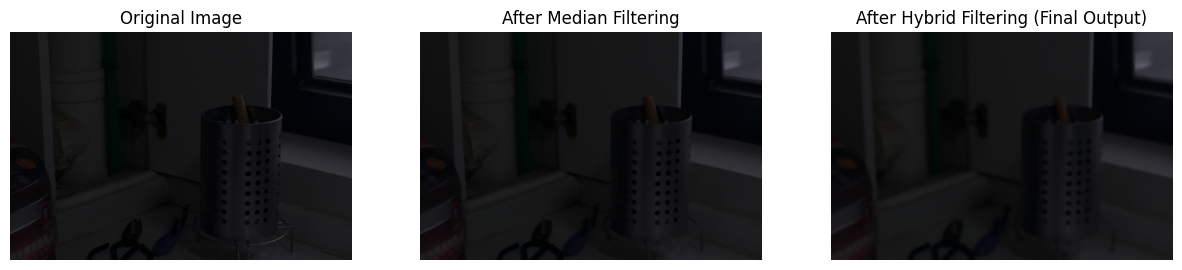

In [27]:
# Display original, median, and final filtered images side by side
fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(median_filtered)
axes[1].set_title("After Median Filtering")
axes[1].axis("off")

axes[2].imshow(bilateral_filtered)
axes[2].set_title("After Hybrid Filtering (Final Output)")
axes[2].axis("off")

plt.show()


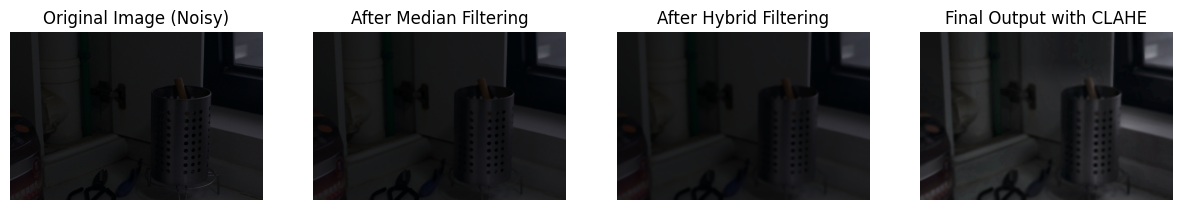

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the noisy image
image = cv2.imread("111.png")  # Change this to your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

# Apply Median Filtering (Removes Salt & Pepper Noise)
median_filtered = cv2.medianBlur(image, 5)

# Apply Bilateral Filtering (Reduces Noise while Preserving Edges)
bilateral_filtered = cv2.bilateralFilter(median_filtered, d=9, sigmaColor=75, sigmaSpace=75)

# Convert to LAB color space
lab = cv2.cvtColor(bilateral_filtered, cv2.COLOR_RGB2LAB)

# Apply CLAHE on the L channel (Brightness channel)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
lab[:,:,0] = clahe.apply(lab[:,:,0])

# Convert back to RGB
final_output = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Display results
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

ax[0].imshow(image)
ax[0].set_title("Original Image (Noisy)")
ax[0].axis("off")

ax[1].imshow(median_filtered)
ax[1].set_title("After Median Filtering")
ax[1].axis("off")

ax[2].imshow(bilateral_filtered)
ax[2].set_title("After Hybrid Filtering")
ax[2].axis("off")

ax[3].imshow(final_output)
ax[3].set_title("Final Output with CLAHE")
ax[3].axis("off")

plt.show()

